In [ ]:
pip install torch torchvision transformers diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
pip install torch torchvision matplotlib numpy


Epoch [1/10] | D Loss: 3.3546 | G Loss: 1.6811


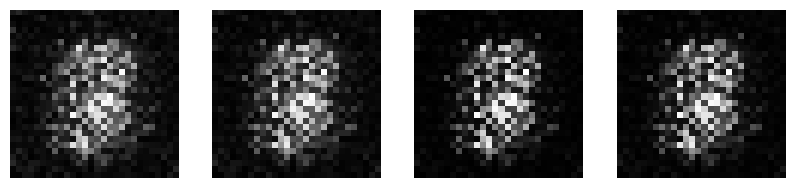

Epoch [2/10] | D Loss: 0.4938 | G Loss: 3.3070
Epoch [3/10] | D Loss: 0.6232 | G Loss: 1.5103
Epoch [4/10] | D Loss: 0.4542 | G Loss: 2.9151
Epoch [5/10] | D Loss: 1.3122 | G Loss: 1.2359
Epoch [6/10] | D Loss: 0.2965 | G Loss: 2.7799
Epoch [7/10] | D Loss: 0.2185 | G Loss: 4.7273
Epoch [8/10] | D Loss: 0.5192 | G Loss: 2.9390
Epoch [9/10] | D Loss: 0.3568 | G Loss: 3.0922
Epoch [10/10] | D Loss: 0.3607 | G Loss: 2.9375


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
image_size = 28*28  # MNIST images are 28x28
latent_dim = 100  # Size of noise vector
batch_size = 64
epochs = 10  # Training iterations
lr = 0.0002  # Learning rate

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, z):
        return self.model(z)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability of real/fake
        )

    def forward(self, img):
        return self.model(img)

# Initialize models
generator = Generator()
discriminator = Discriminator()

# Loss function & optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Load dataset (MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training Loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.view(-1, image_size)  # Flatten images
        batch_size = real_images.size(0)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, latent_dim)  # Generate random noise
        fake_images = generator(z)  # Generate fake images
        fake_outputs = discriminator(fake_images.detach())  # Detach to avoid training generator
        d_loss_fake = criterion(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)  # Try to fool the discriminator
        g_loss = criterion(fake_outputs, real_labels)  # Generator wants output to be 1 (real)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Show generated images every 10 epochs
    if epoch % 10 == 0:
        z = torch.randn(16, latent_dim)
        fake_images = generator(z).detach().numpy().reshape(-1, 28, 28)
        fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
        for img, ax in zip(fake_images[:4], axes):
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        plt.show()

# Save the generator model
torch.save(generator.state_dict(), "generator.pth")


In [ ]:
from diffusers import StableDiffusionPipeline
import torch

# Load the pre-trained model locally
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to("cuda" if torch.cuda.is_available() else "cpu")

# Set your prompt
prompt = "A futuristic city at sunset with flying cars"

# Generate the image
image = pipe(prompt).images[0]

# Save and display the image
image.save("generated_image.png")
image.show()


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
import os
file_path = os.path.abspath("generated_image.png")
print("Image saved at:", file_path)

Image saved at: /content/generated_image.png


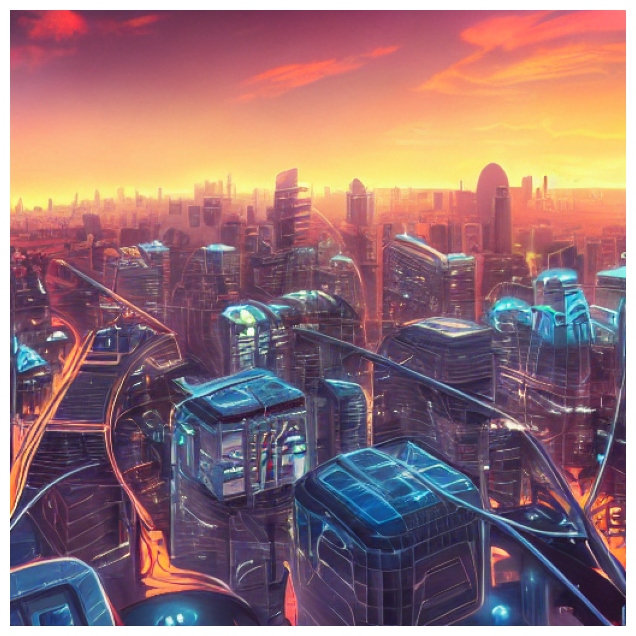

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

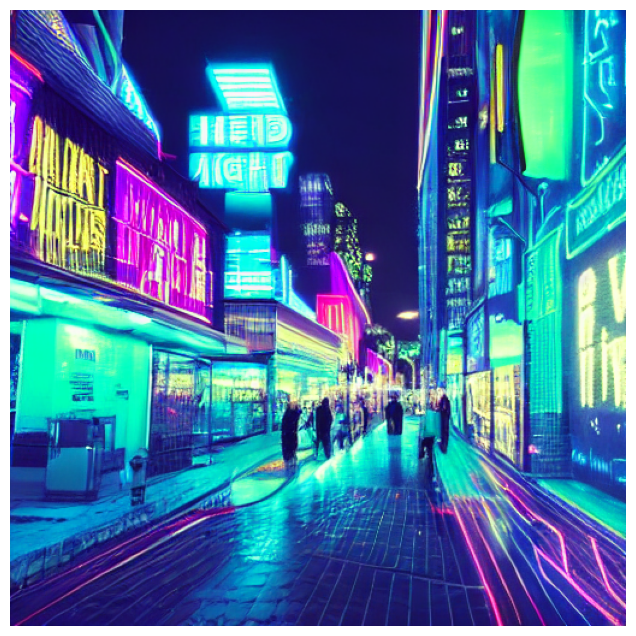

In [ ]:
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
import torch

# Load the pre-trained model once (to avoid reloading it multiple times)
model_path = "runwayml/stable-diffusion-v1-5"  # Change this to your local model path
pipe = StableDiffusionPipeline.from_pretrained(model_path).to("cuda" if torch.cuda.is_available() else "cpu")

def generate_and_plot(prompt):
    """
    Generates an image from a text prompt using Stable Diffusion and plots it.

    Args:
        prompt (str): The text prompt for image generation.
    """
    # Generate image
    image = pipe(prompt).images[0]

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.show()

# Example usage
generate_and_plot("A futuristic city with neon lights at night")


  0%|          | 0/50 [00:00<?, ?it/s]

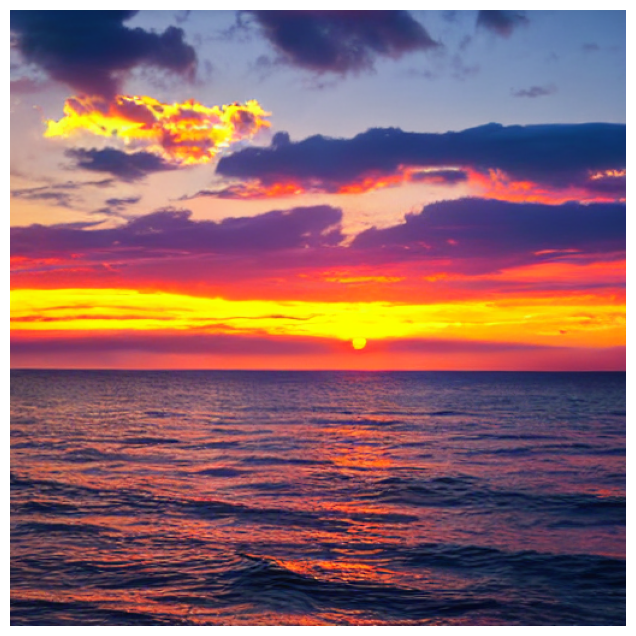

In [ ]:
generate_and_plot("A beautiful sunset over a calm ocean")

  0%|          | 0/50 [00:00<?, ?it/s]

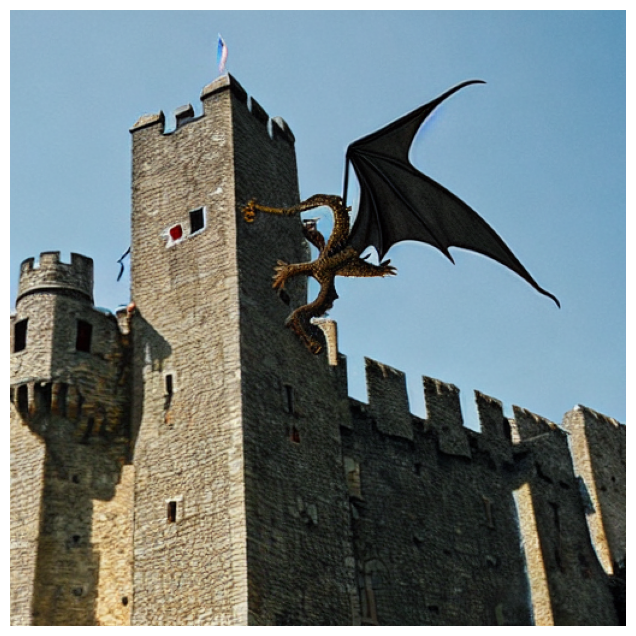

In [ ]:
generate_and_plot("A dragon flying over a medieval castle")

  0%|          | 0/50 [00:00<?, ?it/s]

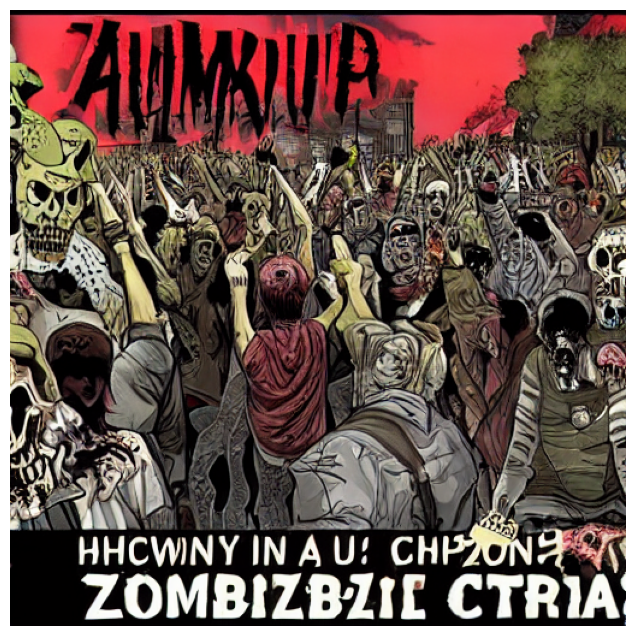

In [ ]:
generate_and_plot("A Zombie apocalypse in a City")